In [1]:
# Basic python packages
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Packages related to images
from PIL import Image
import PIL


In [6]:
def clean_data(path):
    df = pd.read_csv(path)
    df = df[df['Creator'] != ''] 
    df = df[df['Creator'] != 'anoniem']
    df = df[df['Creator'] != 'onbekend']
    df = df[df['Creator'].notna()]
    df = df.replace('Koning, Cornelis (?-1671)', 'Koning, Cornelis')
    return df

def preprocess_data(df, num_artworks = 10):
    df = df.groupby("Creator").filter(lambda x: len(x) >= num_artworks)
    return df

df = clean_data('../Data/Rijksmuseum/xml_files.csv')
rijksdata = preprocess_data(df, 200)

In [7]:
rijksdata

,Identifier,Creator,Title,Date,Type
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz",Keizer Karel V omgeven door zijn overwonnen te...,1555 - 1555,prent
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz",Gevangename van Frans I tijdens de slag van Pa...,1555 - 1556,prent
7,RP-P-1992-70,"Hondius, Hendrick (I)",Vanitasstilleven met een schedel met lauwerkra...,1626 - 1626,prent
100,RP-T-1905-158(R),"Fokke, Simon","Jonge edelman, naar links in gebogen houding",1710 - 1779,tekening
101,RP-T-1905-158(V),"Fokke, Simon",Zittende man,ca. 1710 - ca. 1779,tekening
...,...,...,...,...,...
111960,BK-1977-257-C,M.O.L.,"Deksel, veelkleurig beschilderd met figuren in...",ca. 1774 - ca. 1778,deksel
111961,RP-P-OB-103.253,"Galle, Cornelis (I)",Maria met Kind en de H. Bernardus van Siena en...,1612 - 1633,prent
111962,RP-P-OB-103.254,"Galle, Cornelis (I)",Petrus doopt de H. Prisca van Rome,ca. 1586 - ca. 1610,prent
111966,RP-P-OB-103.260,"Sadeler, Johann (I)",Heilige Apollonia (),1583 - 1587,prent


In [10]:
#Paths to different folders/files
img_list = glob.glob("../Data/Rijksmuseum/jpg2/*.jpg")
image_dir = "../Data/Rijksmuseum/jpg2/"
split_image_dir = "../Data/Rijksmuseum/jpg2_split_200/"

n_labels = len(rijksdata.groupby('Creator').count())

In [11]:
n_labels

88

In [12]:
# labels = pd.read_csv(labels_file)
labels = rijksdata[['Identifier', 'Creator']]
labels

,Identifier,Creator
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz"
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz"
7,RP-P-1992-70,"Hondius, Hendrick (I)"
100,RP-T-1905-158(R),"Fokke, Simon"
101,RP-T-1905-158(V),"Fokke, Simon"
...,...,...
111960,BK-1977-257-C,M.O.L.
111961,RP-P-OB-103.253,"Galle, Cornelis (I)"
111962,RP-P-OB-103.254,"Galle, Cornelis (I)"
111966,RP-P-OB-103.260,"Sadeler, Johann (I)"


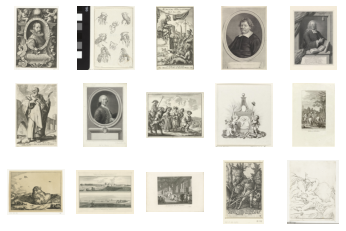

In [13]:
def plot_random_images(img_names, n_x=2, n_y=2, seed=0):
    """
    Plots random images from de data set in a n_x by n_y grid

    :image_names: List with the names of all images
    :n_x: Height of the grid
    :n_x: Width of the grid
    :seed: Seed for the random sample
    :return: nothing
    """ 
    f, axs = plt.subplots(n_x, n_y)
    sample = img_names.sample(n_x * n_y, random_state=seed)
    c = 0
    for x in range(n_x):
        for y in range(n_y):
            img_loc = [item for item in img_list if sample.iloc[c] in item][0]
            img = plt.imread(img_loc)
            axs[x, y].imshow(img)
            axs[x, y].axis('off')
            c += 1

plot_random_images(labels["Identifier"], 3, 5)

In [14]:
labels['Creator'].iloc[0]

'Coornhert, Dirck Volckertsz'

# Reformat data for learning
To be able to load the data with a generator. We must split the training and validation data and place them into a folder based on their label.

In [15]:
def generate_label_folders(image_path, image_names, image_labels, destination_path):
    """
    Splits a single folder with images into multiple folders where images are placed based on their labels.

    :image_path: path to the folder with the images
    :image_names: A numpy array with the names of all images
    :image_labels: A numpy array with the labels of all images
    :destination_path: Path of the folder where the images are placed into
    :return: Nothing
    """ 
    for i in range(len(image_names)):
        if i % 522 == 0:
            print(str(round(i/len(image_names)*100, 3)) + '%')
            
        # Check if the directory exists. Else, make one
        isExist = os.path.exists(os.path.join(destination_path, str(image_labels.iloc[i])))
        if not isExist:
            os.makedirs(os.path.join(destination_path, str(image_labels.iloc[i])))
            
        # Copy the image
        img_loc = [item for item in img_list if image_names.iloc[i] in item][0]
        img = Image.open(img_loc)
        img.save(destination_path + "/" + str(image_labels.iloc[i]) + "/" + image_names.iloc[i] + ".jpg")
        

generate_label_folders(image_dir, labels["Identifier"], labels["Creator"], split_image_dir)

0.0%
1.347%
2.695%
4.042%
5.389%
6.736%
8.084%
9.431%
10.778%
12.125%
13.473%
14.82%
16.167%
17.515%
18.862%
20.209%
21.556%
22.904%
24.251%
25.598%
26.945%
28.293%
29.64%
30.987%
32.334%
33.682%
35.029%
36.376%
37.724%
39.071%
40.418%
41.765%
43.113%
44.46%
45.807%
47.154%
48.502%
49.849%
51.196%
52.544%
53.891%
55.238%
56.585%
57.933%
59.28%
60.627%
61.974%
63.322%
64.669%
66.016%
67.364%
68.711%
70.058%
71.405%
72.753%
74.1%
75.447%
76.794%
78.142%
79.489%
80.836%
82.184%
83.531%
84.878%
86.225%
87.573%
88.92%
90.267%
91.614%
92.962%
94.309%
95.656%
97.003%
98.351%
99.698%
